Epoch [1/50], d_loss: 0.6961, g_loss: 1.1997
Epoch [2/50], d_loss: 0.4152, g_loss: 1.7788
Epoch [3/50], d_loss: 0.4463, g_loss: 1.6864
Epoch [4/50], d_loss: 0.1704, g_loss: 2.4718
Epoch [5/50], d_loss: 0.1071, g_loss: 2.8418
Epoch [6/50], d_loss: 0.3085, g_loss: 2.5076
Epoch [7/50], d_loss: 0.1520, g_loss: 2.9497
Epoch [8/50], d_loss: 0.1135, g_loss: 3.0677
Epoch [9/50], d_loss: 0.1738, g_loss: 2.8931
Epoch [10/50], d_loss: 0.1479, g_loss: 3.0278
Epoch [11/50], d_loss: 0.1843, g_loss: 3.1263
Epoch [12/50], d_loss: 0.0746, g_loss: 3.2779
Epoch [13/50], d_loss: 0.0462, g_loss: 3.3343
Epoch [14/50], d_loss: 0.2502, g_loss: 3.3530
Epoch [15/50], d_loss: 0.0333, g_loss: 3.4732
Epoch [16/50], d_loss: 0.1672, g_loss: 3.6186
Epoch [17/50], d_loss: 0.0471, g_loss: 3.6277
Epoch [18/50], d_loss: 0.1022, g_loss: 3.6191
Epoch [19/50], d_loss: 0.0691, g_loss: 3.6494
Epoch [20/50], d_loss: 0.2986, g_loss: 3.7977
Epoch [21/50], d_loss: 0.1143, g_loss: 4.0312
Epoch [22/50], d_loss: 0.0258, g_loss: 4.23

/home/nemo/apps/source/develop/lab-master/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nemo/apps/source/develop/lab-master/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nemo/apps/source/develop/lab-master/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

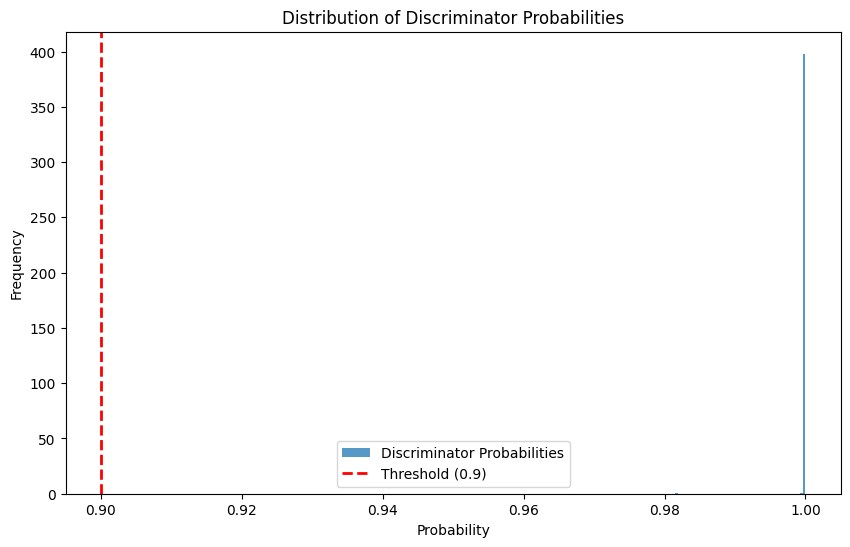

In [31]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# 1. Đọc và chuẩn hóa dữ liệu
data = pd.read_csv('../../data/ai4i2020.csv')
features = data.drop(columns=['UDI', 'Product ID', 'Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
labels = data['Machine failure']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# 2. Chia dữ liệu: Train với 8000 dòng bình thường và Test với 200 bình thường + 200 bất thường
X_train = scaled_features[labels == 0][:8000]
normal_test = scaled_features[labels == 0][8000:8200]
anomaly_test = scaled_features[labels == 1][:200]

# Gộp tập kiểm tra (400 dòng)
X_test = np.vstack([normal_test, anomaly_test])
y_test = np.hstack([np.zeros(200), np.ones(200)])  # Nhãn tương ứng

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 3. Định nghĩa Generator và Discriminator
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 4. Khởi tạo mô hình và optimizer
latent_dim = 10
input_dim = X_train.shape[1]

generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# 5. Huấn luyện GAN với 8000 dòng bình thường
epochs = 50
batch_size = 32
train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for real_data in train_loader:
        # Huấn luyện Discriminator
        optimizer_d.zero_grad()
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        noise = torch.randn(batch_size, latent_dim)
        fake_data = generator(noise)

        real_loss = nn.BCELoss()(discriminator(real_data), real_labels)
        fake_loss = nn.BCELoss()(discriminator(fake_data.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_d.step()

        # Huấn luyện Generator
        optimizer_g.zero_grad()
        noise = torch.randn(batch_size, latent_dim)
        generated_data = generator(noise)
        g_loss = nn.BCELoss()(discriminator(generated_data), real_labels)
        g_loss.backward()
        optimizer_g.step()

    print(f'Epoch [{epoch + 1}/{epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

# 6. Dự đoán trên tập kiểm tra
discriminator.eval()
with torch.no_grad():
    test_probs = discriminator(X_test_tensor).numpy().flatten()

# 7. Đánh dấu dữ liệu dựa trên xác suất P
threshold = 0.5  # Nếu P >= 0.5 thì bình thường, ngược lại bất thường
y_pred = (test_probs >= threshold).astype(int)

# 8. In Confusion Matrix và Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 9. Tính ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc}")

# 10. Vẽ biểu đồ phân phối xác suất dự đoán
plt.figure(figsize=(10, 6))
plt.hist(test_probs, bins=50, alpha=0.75, label='Discriminator Probabilities')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold ({threshold})')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Discriminator Probabilities')
plt.legend()
plt.show()